In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from top2vec import Top2Vec

from helpers.infodynamics import InfoDynamics
from helpers.metrics import jsd, kld, cosine_distance, softmax
from helpers.afa import adaptive_filter
from tqdm import tqdm
from helpers.visuals import add_cabinet_periods

with open('config.json','r') as f:
    cf = json.load(f)

mbd = pd.read_csv('/home/rb/Documents/PhD/Code/resources/member-party-change-date.tsv',sep='\t')
mbd = mbd.drop_duplicates(['member-ref'],keep='first')
mbd = dict(zip(mbd['member-ref'],mbd['party-ref']))

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ntr_df = pd.read_json('results/novelty_w30.ndjson')
data = pd.read_json(cf['data_path'],lines=True)
metadata = pd.read_csv(cf['metadata_path'],sep='\t',parse_dates=['date'])
cabs = pd.read_csv('resources/cabinets.csv',parse_dates=['startdate','enddate']).iloc[10:19,:]

/tmp/ipykernel_1643/2174885357.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cabs = pd.read_csv('resources/cabinets.csv',parse_dates=['startdate','enddate']).iloc[10:19,:]
/tmp/ipykernel_1643/2174885357.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cabs = pd.read_csv('resources/cabinets.csv',parse_dates=['startdate','enddate']).iloc[10:19,:]


In [3]:
metadata = metadata[metadata.role != 'chair'].reset_index(drop=True)

In [10]:
timestamps = metadata.date.tolist()

In [12]:
from datetime import datetime, timedelta

In [15]:
timestamps[5] - timedelta(days=10)

Timestamp('1946-01-12 00:00:00')

In [17]:
m = len(metadata)
time_window = 10
r = []

for index_ in np.arange(m):
    target_date = timestamps[index_]
    window_delim_date = target_date - timedelta(days=time_window)
    window_indices = [index__ for index__,date in enumerate(timestamps) if date >= window_delim_date and index__ < index_]
    r.append({"index_":index_,"date":target_date,"num_texts":})


1946-01-22 00:00:00 0
1946-01-22 00:00:00 1
1946-01-22 00:00:00 2
1946-01-22 00:00:00 3
1946-01-22 00:00:00 4
1946-01-22 00:00:00 5
1946-01-22 00:00:00 6
1946-01-22 00:00:00 7
1946-01-22 00:00:00 8
1946-01-22 00:00:00 9
1946-01-22 00:00:00 10
1946-01-22 00:00:00 11
1946-01-22 00:00:00 12
1946-01-22 00:00:00 13
1946-01-22 00:00:00 14
1946-01-22 00:00:00 15
1946-01-22 00:00:00 16
1946-01-22 00:00:00 17
1946-01-22 00:00:00 18
1946-01-22 00:00:00 19
1946-01-22 00:00:00 20
1946-01-22 00:00:00 21
1946-01-22 00:00:00 22
1946-01-22 00:00:00 23
1946-02-20 00:00:00 0
1946-02-20 00:00:00 1
1946-02-20 00:00:00 2
1946-02-20 00:00:00 3
1946-02-20 00:00:00 4
1946-02-20 00:00:00 5
1946-02-20 00:00:00 6
1946-02-20 00:00:00 7
1946-02-20 00:00:00 8
1946-02-20 00:00:00 9
1946-02-20 00:00:00 10
1946-02-20 00:00:00 11
1946-02-20 00:00:00 12
1946-02-20 00:00:00 13
1946-02-20 00:00:00 14
1946-02-20 00:00:00 15
1946-02-20 00:00:00 16
1946-02-20 00:00:00 17
1946-02-20 00:00:00 18
1946-02-20 00:00:00 19
1946-02-

KeyboardInterrupt: 

In [4]:
dat2 = []
for cab,mtd in cabs.iterrows():
    mask = ((metadata.date >= mtd['startdate']) & (metadata.date < mtd['enddate']))
    metadata_cab = metadata.loc[mask]
    if len(metadata_cab) == 0:
        continue
    metadata_cab['pt'] = metadata_cab['member-ref'].apply(lambda x: mbd.get(x))
    parties = ['nl.p.'+m for m in mtd['coalition_parties'].split(';')]
    metadata_cab['coalition'] = ['coalition' if r['pt'] in parties or r['role'] == 'government' else 'opposition' for i,r in metadata_cab.iterrows()]
    dat2.append(metadata_cab)

/tmp/ipykernel_259/314725007.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_cab['pt'] = metadata_cab['member-ref'].apply(lambda x: mbd.get(x))
/tmp/ipykernel_259/314725007.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_cab['coalition'] = ['coalition' if r['pt'] in parties or r['role'] == 'government' else 'opposition' for i,r in metadata_cab.iterrows()]
/tmp/ipykernel_259/314725007.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [5]:
dat2 = pd.concat(dat2)

In [6]:
dat2['profile'] = dat2[['coalition','role']].astype(str).agg('-'.join,axis=1)

In [7]:
ntr_df['role'] = dat2['profile']
ntr_df['date'] = metadata['date']

In [8]:
agg_ntr = ntr_df.groupby([ntr_df.role,ntr_df.date.dt.to_period('M')]).mean().reset_index()

/tmp/ipykernel_259/2109576280.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_ntr = ntr_df.groupby([ntr_df.role,ntr_df.date.dt.to_period('M')]).mean().reset_index()


coalition-government
coalition-mp
opposition-mp


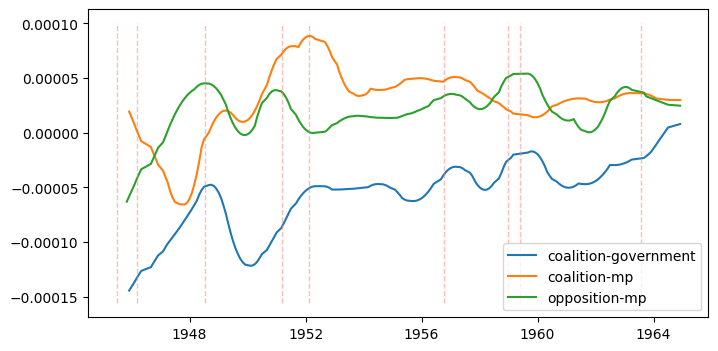

In [9]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

for r,d in agg_ntr.groupby('role'):
    print(r)
    ax.plot(d.date.dt.to_timestamp(),adaptive_filter(d.resonance,span=28),label=r)
ax.legend()
add_cabinet_periods(ax=ax,max_time=1965,min_time=1945,cab_df=cabs,text=False)

In [14]:
pcdict = {'nl.p.sdap': 'nl.p.pvda',
 None: None,
 'nl.p.algemeenebond': 'kvp',
 'nl.p.pvda': 'nl.p.pvda',
 'nl.p.arp': 'nl.p.arp',
 'nl.p.vb': 'nl.p.vvd',
 'nl.p.rksp': 'nl.p.kvp',
 'nl.p.vdb': 'nl.p.vvd',
 'nl.p.sgp': 'nl.p.sgp',
 'nl.p.cpn': 'nl.p.cpn',
 'nl.p.cdu': 'nl.p.cdu',
 'nl.p.chu': 'nl.p.chu',
 'nl.p.kvp': 'nl.p.kvp',
 'nl.p.pvdv': 'nl.p.vvd',
 'nl.p.knp': 'nl.p.knp',
 'nl.p.vvd': 'nl.p.vvd',
 'nl.p.cg': 'nl.p.cg',
 'nl.p.psp': 'nl.p.psp',
 'nl.p.gpv': 'nl.p.gpv',
 'nl.p.bp': 'nl.p.bp'}

In [19]:
dat2['pt-corr'] = dat2.pt.apply(lambda x: pcdict.get(x))
ntr_df['pt'] = dat2['pt-corr']

In [32]:
pcolors = {'nl.p.pvda': 'firebrick',
 'nl.p.vvd': 'darkorange',
 'nl.p.arp': 'darkgreen',
 'nl.p.chu': 'lightseagreen',
 'nl.p.kvp': 'gold',
 'nl.p.cpn': 'orangered'}

In [20]:
agg_ntr_p = ntr_df.groupby([ntr_df.pt,ntr_df.date.dt.to_period('M')]).mean().reset_index()

/tmp/ipykernel_259/3601267406.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_ntr_p = ntr_df.groupby([ntr_df.pt,ntr_df.date.dt.to_period('M')]).mean().reset_index()


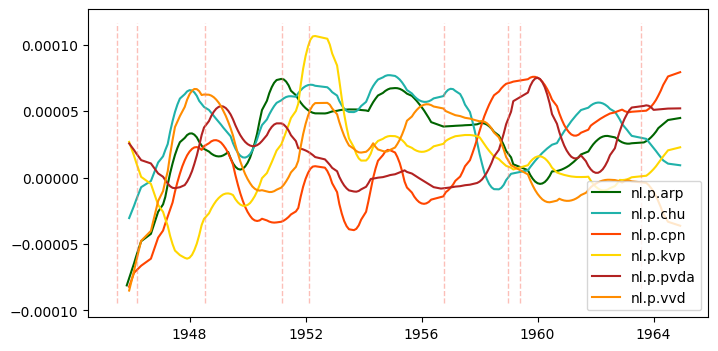

In [36]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

for r,d in agg_ntr_p.groupby('pt'):
    if r in pcolors.keys():
        ax.plot(d.date.dt.to_timestamp(),adaptive_filter(d.resonance,span=5 if len(d) <= 10 else 28),label=r,color=pcolors[r])
ax.legend()
add_cabinet_periods(ax=ax,max_time=1965,min_time=1945,cab_df=cabs,text=False)


In [26]:
len(d)

10

In [24]:
adaptive_filter(d.resonance,span=5)

matrix([[-1.41922182e-04],
        [-1.13872029e-04],
        [-8.58218770e-05],
        [-5.77717246e-05],
        [-2.97215723e-05],
        [-1.50007899e-05],
        [ 1.93454863e-05],
        [ 7.33172563e-05],
        [ 1.46914520e-04],
        [ 2.14215660e-04]])